# Challenge Problem 3: Genome Wide Association Study

## Background:

(Adapted From BMI 704, Dr. Chirag Patel)

Genome-wide association studies (GWASs) are arguably the most significant biomedical advance in the last decade. Utilizing an observational case-control design, populations with disease are analytically compared to those without to discern patterns in differences in genetic variant, or single nucleotide polymorphism (SNP),frequencies in each of the respective populations. If statistically differences in SNP frequencies in cases vs
controls are found, one can conclude the SNP locus may have a causal relationship, implicating a gene, genetic region, or gene regulator in the disease of interest.

Analyzing GWASs provide lessons in observational research, including statistical association and multiple testing. They also provide a way to create hypotheses about biological basis of disease for further study. We will execute a GWAS analysis using data from the Wellcome Trust Case-Control Consortium (WTCCC) on Type 2 Diabetes, Type 1 Diabetes, Bipolar Disorder, Rheumatoid Arthritis, Chron's Disease and Hypertension versus 1,500 controls.

Note: There are standard tools and pipelines available to do this but we will do it the old fashioned way!

The Data is provided in separate directories under the primary WTCCC directory. The subdirectories are labeled as such:
* 58C : control population 1
* NBS : control population 2
* RA : rheumatoid arthritis
* T2D : type 2 diabetes
* T1D : type 1 diabetes
* CAD : coronary artery disease
* HT : hypertension
* CD : Crohn’s disease
* BD : bipolar disorder

All of the GWAS data is broken down per chromosome, 1-22 plus X and is written into the file name, as well as the disease. For example:

Affx_gt_ 58C _Chiamo_ 06 .tped.gz

Contains GWAS data for the 6th (06) chromosome on control population 1 (58C). The biggest files are chromosome 1 and 2 and smallest is 22.


Each row is a SNP (there are 6207 SNPs measured in Chromosome 22). The first through fourth columns denote the chromosome number, the second is the WTCCC snp_id (not to be confused with the rsid), the start coordinate (0), and the end coordinate. Thereafter, each column is a genotype (where each base is separated by a space character) for that SNP for each individual.

Additionally, each subdirectory also contains a ‘snps_info.tar.gz’, which contains the snp_id and rsID for each SNP for each chromosome. These files can enable you to map the WTCCC snp_id to the rsid, which is helpful to find the closest genes to a SNP (for example when you query the GWAS catalog).

In [1]:
import pandas as pd
from os import path
import csv
import numpy as np
from time import time
from scipy.stats import chisquare
import scipy
import matplotlib.pyplot as plt

In [192]:
######## CLASS NOTES ON WHAT TO DO ##################

In [488]:
## Load the test data 
t2d_22_file = 'BWSI_100set/T2D/Affx_gt_T2D_Chiamo_22.tped.gz' ##########THE OG CODE SAID BWSI_test INSTEAD OF BWSI_100set
t2d = pd.read_csv(t2d_22_file, compression='gzip', header=None, sep='\t')
c1 = pd.read_csv('BWSI_100set/58C/Affx_gt_58C_Chiamo_22.tped.gz', compression='gzip', header=None,sep='\t')
c2 = pd.read_csv('BWSI_100set/NBS/Affx_gt_NBS_Chiamo_22.tped.gz', compression='gzip', header=None,sep='\t')
snp = pd.read_csv('BWSI_100set/58C/snps/snps_22',header=None, sep='\t')
t2d_head = t2d.loc[:,0:3]
t2d_snps = t2d.loc[:,4:]
c1_head = c1.loc[:,0:3]
c1_snps = c1.loc[:,4:]
c2_head = c2.loc[:,0:3]
c2_snps = c2.loc[:,4:]
snp = snp.drop([0,1],axis=1)
snp = snp.rename(columns={3:'snp_name',4:'rs'} )
c1_head = c1_head.rename(columns={1:'snp_name'})
snp=snp.drop([2],axis=1)
snp_c1_joined = c1_head.join(snp.set_index('snp_name'), on='snp_name')
t2d_1 = t2d_snps.loc[0,:]
c1_1 = c1_snps.loc[0,:]

In [2]:
##1 compute Allele Frequency for the minor allele
def computeAlleleFrequency (f_C, f_T):
    """3
    f_C = minor allele count
    f_T = major allele count
    minor_allele_frequency = f_C/ (f_C+f_T) 
    7"""
    minor_allele_frequency = f_C/(f_C+f_T)
    return minor_allele_frequency

def getAlleleCounts (genotype):
    """ 12
    genotype = "C C 	C T 	C T 	C T 	T T"
    Allele frequency:
    count the "Cs", and the "Ts"
    f_C = # of Cs
    f_T = # of T's
    18"""
    dicto = {}
    stro = genotype.to_string()
    if stro.count('C')!=0:
        dicto.update({'C': stro.count('C')})
    if stro.count('T')!=0:
        dicto.update({'T': stro.count('T')})
    if stro.count('G')!=0:
        dicto.update({'G': stro.count('G')})
    if stro.count('A')!=0:
        dicto.update({'A': stro.count('A')})
    if len(dicto)==1:
        dicto.update({'-1':0})
    return dicto

def getGenotypeCounts (genotype):
    stro = genotype.to_string()
    cc = stro.count('C C')
    tt = stro.count('T T')
    aa = stro.count('A A')
    ag = stro.count('A G')
    gg = stro.count('G G')
    if cc==0 and tt==0:
        return np.array([aa,ag+stro.count('G A'),gg])
    elif gg==0 and tt==0: 
        return np.array([aa,stro.count('A C')+stro.count('C A'),cc])
    elif gg==0 and aa==0: 
        return np.array([cc,stro.count('C T')+stro.count('T C'),tt])
    else:
        return np.array([tt,stro.count('G T')+stro.count('T G'),gg])

#30 # Compute the Odds Ratio
#31 # takes as input a 2X2  confusion matrix
#32 # returns the odds ratio
def computeOR(health,diabetic):
    if health[0] ==0 or diabetic[1]==0:
        return 0
    else:
        return diabetic[0]*health[1]/(health[0]*diabetic[1])

#36 # Execute a chisq test to determine if the odds ratio is significant
#37 # return the p-value from the chisq test

def getPValue(confusionMatrix):
    from scipy.stats import chi2_contingency
    chi2, p, dof, exptected = chi2_contingency(confusionMatrix)
    return p

def get_snp_stats(control, disease):
    
    health_v = list(getAlleleCounts(control).values())
    health_k = list(getAlleleCounts(control))
    diabetic_v = list(getAlleleCounts(disease).values())
    diabetic_k = list(getAlleleCounts(disease))
    
# 59    dis_freq = computeAlleleFrequency(diabetic[0], diabetic[1])
# 60    health_freq =  computeAlleleFrequency(health[0], health[1])

    o_r= computeOR(health_v,diabetic_v) # odds ratio
    
    
    minor_allele_con = health_k[0]
    major_allele_con = health_k[1]
    minor_allele_dis = diabetic_k[0]
    major_allele_dis = diabetic_k[1]

    t1_minor = computeAlleleFrequency(diabetic_v[0], diabetic_v[1])
    t1_major = 1 - t1_minor
    control_minor = computeAlleleFrequency(health_v[0], health_v[1])
    control_major = 1-control_minor
    
    mx = pd.DataFrame({'col1':[diabetic_v[0], health_v[0]], 'col2':[diabetic_v[1],health_v[1]]})
    try:
        p = getPValue(mx)
    except:
        p=1

    if control.to_string().count('C C')!=0 and control.to_string().count('C T')!=0 and control.to_string().count('T T')!=0:
        HWE = HWEChiSq(control_minor, getGenotypeCounts(control))
    else:
        HWE = HWEChiSq(control_minor, getGenotypeCounts(control))
    
    
    result=  pd.DataFrame(np.array([minor_allele_con,major_allele_con,minor_allele_dis,major_allele_dis,control_minor,t1_minor,o_r,p,HWE]))
    return result
    
## function to load the data file
def loadFile (disease, chrom_num):
    ## construct your file name based on the disease and chrom_number
    if chrom_num<10:
        stro = '0'+str(chrom_num)
    else:
        stro = str(chrom_num)
    fileName = 'BWSI_100set/'+disease+'/Affx_gt_'+disease+'_Chiamo_'+stro+'.tped.gz'
    dat = pd.read_csv(fileName, compression='gzip', header=None, sep='\t')
    return (dat)

In [30]:
import time
bigdf = pd.DataFrame()
snpsid = pd.DataFrame()
for i in range(22):
    
    now = time.time()
    i = i+1
    print("Doing Chromosome "+str(i)+"...")
    t2d = loadFile('T2D',i)
    c1 = loadFile('58C',i)
    
    if i<10:
        stro = '0'+str(i)
    else:
        stro = str(i)
    snp = pd.read_csv('BWSI_100set/58C/snps/snps_'+stro,header=None, sep='\t')
    snp = snp.iloc[:100,:]
    
    t2d_head = t2d.loc[:,0:3]
    t2d_snps = t2d.loc[:,4:]
    c1_head = c1.loc[:,0:3]
    c1_snps = c1.loc[:,4:]
    
    snp = snp.drop([0,1],axis=1)
    snp = snp.rename(columns={3:'snp_name',4:'rs'} )
    
    c1_head = c1_head.rename(columns={1:'snp_name'})
    t2d_head = t2d_head.rename(columns={1:'snp_name'})
    c1_head = c1_head.drop([0,2],axis=1)
    t2d_head = t2d_head.drop([0,2],axis=1)
    
    snp=snp.drop([2],axis=1)
    df = pd.DataFrame()
    #snpsid = snpsid.append(snp)
    joined_con=c1_head.join(snp.set_index('snp_name','rs'), on='snp_name')
    #joined_dis=t2d_head.join(snp.set_index('snp_name','rs'),on='snp_name')
    snpsid = snpsid.append(joined_con)
    
    for j in range(100):
        t2d_1 = t2d_snps.loc[j,:]
        c1_1 = c1_snps.loc[j,:]
        df=df.append(get_snp_stats(c1_1,t2d_1).transpose())
#         snpsid = snpsid.append(pd.DataFrame(snp.iloc[j,0]))

    bigdf=bigdf.append(df)

Doing Chromosome 1...


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in double_scalars


Doing Chromosome 2...
Doing Chromosome 3...
Doing Chromosome 4...


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


Doing Chromosome 5...
Doing Chromosome 6...
Doing Chromosome 7...
Doing Chromosome 8...
Doing Chromosome 9...
Doing Chromosome 10...
Doing Chromosome 11...
Doing Chromosome 12...
Doing Chromosome 13...
Doing Chromosome 14...
Doing Chromosome 15...
Doing Chromosome 16...
Doing Chromosome 17...
Doing Chromosome 18...
Doing Chromosome 19...
Doing Chromosome 20...
Doing Chromosome 21...
Doing Chromosome 22...


In [32]:
snpsid.head()

,snp_name,3,rs
0,SNP_A-1938722,15385344,NaN
1,SNP_A-4217222,243847383,NaN
2,SNP_A-2023862,192847341,NaN
3,SNP_A-4196224,95890895,NaN
4,SNP_A-2286934,189084167,NaN


In [33]:
snpsid.reset_index(drop=True, inplace=True)
bigdf.reset_index(drop=True, inplace=True)
a = pd.concat([snpsid,bigdf],axis=1)
a = a.rename(columns={0: 'con min all', 1: "dis min all",2:'con maj all',3:'dis maj all',4:'con maj all freq',5:'dis maj all freq',6:'odds rat',7:'p',8:'HWE'})

In [36]:
arr = np.array([])
for i in range(22):
    i=i+1
    for j in range(100):
        arr=np.append(arr,i)
arr

array([ 1.,  1.,  1., ..., 22., 22., 22.])

In [37]:
chro = pd.DataFrame(arr)
a.insert(0,'chr',chro)

In [39]:
a.to_csv('gene_data.csv')

In [269]:
snpsid = pd.DataFrame(columns = ["snp_name","rsid"])
for i in range(22):
    i = i+1
    
    if i<10:
        stro = '0'+str(i)
    else:
        stro = str(i)
    snp = pd.read_csv('BWSI_100set/58C/snps/snps_'+stro,header=None, sep='\t')
    
    snp = snp.drop([0,1],axis=1)
    snp = snp.drop([2],axis=1)
    
    snp = snp.rename(columns={3:'snp_name',4:'rsid'} )
    print(snp.head())
    snpsid = snpsid.append(snp)
    print(snpsid.head())
    

        snp_name      rsid
0  SNP_A-4221087  rs307378
1  SNP_A-2203152  rs474731
2  SNP_A-4198280  rs485777
3  SNP_A-1861214  rs492861
4  SNP_A-1860431  rs496723
        snp_name      rsid
0  SNP_A-4221087  rs307378
1  SNP_A-2203152  rs474731
2  SNP_A-4198280  rs485777
3  SNP_A-1861214  rs492861
4  SNP_A-1860431  rs496723
        snp_name       rsid
0  SNP_A-2272612  rs4247179
1  SNP_A-2289056  rs4675917
2  SNP_A-4199218  rs4675920
3  SNP_A-2308630  rs6437265
4  SNP_A-4292663  rs6437282
        snp_name      rsid
0  SNP_A-4221087  rs307378
1  SNP_A-2203152  rs474731
2  SNP_A-4198280  rs485777
3  SNP_A-1861214  rs492861
4  SNP_A-1860431  rs496723
        snp_name      rsid
0  SNP_A-2039407  rs736480
1  SNP_A-1972592  rs743660
2  SNP_A-2275659  rs743661
3  SNP_A-1974174  rs804968
4  SNP_A-1974175  rs804974
        snp_name      rsid
0  SNP_A-4221087  rs307378
1  SNP_A-2203152  rs474731
2  SNP_A-4198280  rs485777
3  SNP_A-1861214  rs492861
4  SNP_A-1860431  rs496723
        snp_name      

In [ ]:
for i in range(22):
    i=i+1
    if i<10:
        stro = '0' + str(i)
    else:
        stro = str(i)
    snp = pd.read_csv('BWSI_100set/58C/snps/snps_'+stro,header=None, sep='\t')
    for j in range(100):
        snpid.iloc[j,1] = snp.iloc[j,1]

In [146]:
bigdf = bigdf.rename(columns={0:'Con Minor Allele',1:'Con Major Allele',2:'Dis Minor Allele',3:'Dis Major Allele',4:'Con Minor Allele Freq',5:'Dis Minor Allele Freq',6:'Odds Ratio',7:'P value',8:'HWE'})

In [75]:
print("Odds Ratio:")
print(str(computeOR(getAlleleCounts(c1_1),getAlleleCounts(t2d_1))))

print("\nType 2 Diabetes:")
print(computeAlleleFrequency(getAlleleCounts(t2d_1)[0], getAlleleCounts(t2d_1)[1]))

t1_minor = computeAlleleFrequency(getAlleleCounts(t2d_1)[0], getAlleleCounts(t2d_1)[1])
t1_major = 1 - t1_minor
control_minor = computeAlleleFrequency(getAlleleCounts(c1_1)[0], getAlleleCounts(c1_1)[1])
control_major = 1-control_minor

print(getPValue([t1_minor, t1_major]))
print(getPValue([control_minor, control_major]))

print(1-computeAlleleFrequency(getAlleleCounts(t2d_1)[0], getAlleleCounts(t2d_1)[1]))
print("\nControl:")
print(computeAlleleFrequency(getAlleleCounts(c1_1)[0], getAlleleCounts(c1_1)[1]))

print(1-computeAlleleFrequency(getAlleleCounts(c1_1)[0], getAlleleCounts(c1_1)[1]))

# print(control)

print("\nChi-Squared:")
print(getPValue([t1_minor, t1_major,control_minor, control_major]))

print("\nHWE:")
print(HWEChiSq(control_minor, [c1_1.to_string().count('C C'), c1_1.to_string().count('C T'), c1_1.to_string().count('T T')]))


Odds Ratio:
0.9963249409766973

Type 2 Diabetes:
0.38244122061030517
0.8141174907213498
0.8154681593364395
0.6175587793896948

Control:
0.38331117021276595
0.616688829787234

Chi-Squared:
0.9906428272745443

HWE:
0.9149630590292988


,0
0,1153.000000
1,1855.000000
2,1529.000000
3,2469.000000
4,0.383311
5,0.382441
6,0.996325
7,0.990643
8,0.914963


In [ ]:
snp = np.array([])
for i in range(22):
    i = i+1
    print("Chromosome "+ str(i)+"...")
    if i<10:
        stro = '0'+str(i)
    else:
        stro=str(i)
    dat = pd.read_csv('BWSI_100set/58C/snps/snps_'+stro,header=None, sep='\t')
    dat = dat.drop([0,1],axis=1)
    snpid = dat.loc[:,3]
    for j in snpid:
        snp=np.append(snp,j)



In [178]:
snp

array(['SNP_A-2203152', 'SNP_A-4198280'], dtype='<U32')

In [167]:
snp.shape

(22, 41400)

In [165]:
dat = pd.read_csv('BWSI_100set/58C/snps/snps_01',header=None, sep='\t')
dat = dat.drop([0,1],axis=1)
dat.head()
snpid = dat.loc[:,3]


0    SNP_A-4221087
1    SNP_A-2203152
2    SNP_A-4198280
3    SNP_A-1861214
4    SNP_A-1860431
Name: 3, dtype: object

## Hardy Weinberg Equilibrium

In [469]:
df.head(10)

,chr,snp_name,rs,con min all,dis min all,con maj all,dis maj all,con maj all freq,dis maj all freq,odds rat,p,HWE,p_adj,ind
0,1.0,SNP_A-4221087,rs307378,C,T,C,T,0.530918,0.558279,1.116672,0.999392,0.922660,0.000264,0
1,1.0,SNP_A-2203152,rs474731,C,T,C,T,0.349069,0.336168,0.944326,0.977834,0.148283,0.009735,1
10,1.0,SNP_A-4285953,rs573378,C,T,C,T,0.249003,0.246873,0.988646,0.917066,0.809476,0.037599,2
19,1.0,SNP_A-2190868,rs948620,C,T,C,T,0.243351,0.239370,0.978491,0.911096,0.125741,0.040436,3
20,1.0,SNP_A-4264596,rs962923,T,G,T,G,0.766290,0.763882,0.986692,0.905034,0.756994,0.043335,4
24,1.0,SNP_A-2105952,rs1551623,T,G,T,G,0.485705,0.491246,1.022423,0.999990,0.311357,0.000004,5
32,1.0,SNP_A-1942655,rs1942230,C,T,C,T,0.050532,0.048024,0.947866,0.653686,0.089492,0.184631,6
33,1.0,SNP_A-2185523,rs2008906,C,T,C,T,0.282580,0.286143,1.017664,0.945959,0.602344,0.024128,7
36,1.0,SNP_A-2219293,rs2156040,T,G,T,G,0.797872,0.783142,0.914864,0.878930,0.683108,0.056046,8
37,1.0,SNP_A-1900004,rs2156042,T,G,T,G,0.381316,0.391446,1.043651,0.991417,0.289793,0.003744,9


In [3]:
## Function takes as input the minor allele frequency (p) and the population genotype counts
## returns the p-value from the chisq test
def HWEChiSq (p, populationGenotypeCounts):
    """
        |  CC | CT  | TT |
    BP  | 270 | 957 | 771|
    compute the HWE
      -- p = frequency of the C allele
      -- q = 1-p = frequency of the T allele
      -- if the population genotype is in Hardy Weinberg Equilibrium, we would expect the genotype frequencies to be
          CC = p^2*N 
          CT = 2pq*N 
          TT = q^2*N 
      -- to compute the deviation from HWE
         (observed - expected)^2 / expected
      -- do a chi.squared test to check if the deviation is significant
    """
    total = sum(populationGenotypeCounts)
        
    q = 1-p
    
    observed = populationGenotypeCounts[0]
    expected = p**2*total
    
    CC = (observed-expected)**2/expected
    
    
    observed = populationGenotypeCounts[1]
    expected = 2*p*q*total
    
    CT = (observed-expected)**2/expected
    
    observed = populationGenotypeCounts[2]
    expected = q**2*total
    
    TT = (observed-expected)**2/expected
    
    from scipy.stats import chisquare
    from scipy.stats.distributions import chi2
    return chi2.sf(CC+CT+TT, 1)

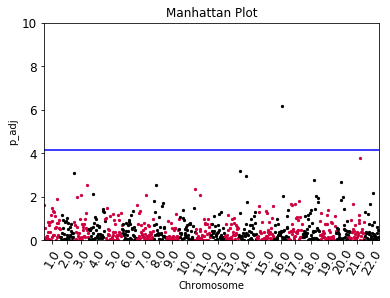

In [199]:
## plot the data
## manhattan plot
## the X axis represents the chromosomes 
## the y-axis is the -log(p.value)

pd.set_option('expand_frame_repr', False)
df = pd.read_csv('gene_data.csv')
df= df.iloc[:,1:]
df.head()
    # HWE<0.05
    # allfreq<0.01

df = df[df['HWE']>=0.05]
df = df[df['con maj all freq']>=0.01]
df = df[df['dis maj all freq']>=0.01]


df['p_adj'] = -np.log10(df['p'])
df['chr'] = df['chr'].astype('category')

    # print(df.head(10))

df['ind'] = range(len(df))
df_grouped = df.groupby(('chr'))

    # print(df_grouped.head(10))

fig = plt.figure()
ax = fig.add_subplot(111)
colors = ['#cf003d','#000000']
x_labels = []
x_labels_pos = []
for num, (name, group) in enumerate(df_grouped):
    group.plot(kind='scatter', x='ind', y='p_adj',color=colors[num % len(colors)], ax=ax, s=5)
    x_labels.append(name)
    x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2))

ax.set_xticks(x_labels_pos)
ax.set_xticklabels(x_labels)
ax.set_xlim([0, len(df)])
ax.set_ylim([0, 10])
ax.set_xlabel('Chromosome')
plt.xticks(fontsize = 12,rotation=60)
plt.title('Manhattan Plot')
plt.yticks(fontsize = 12)

        # xticks = ax.xaxis.get_major_ticks()
        # xticks[0].set_visible(False)
plt.axhline(y=-np.log10(0.05/len(df)),color='b')
plt.show()

In [62]:
sigsnps = df[df['p_adj']>=-np.log10(0.05/len(df))]

,chr,snp_name,dis maj all,rs,con min all,dis min all,con maj all,dis maj all.1,con maj all freq,dis maj all freq,odds rat,p,HWE,p_adj,ind
1556,16.0,SNP_A-2037492,52368187,NaN,C,T,C,T,0.394614,0.454227,1.276793,6.822692e-07,0.931499,6.166044,521


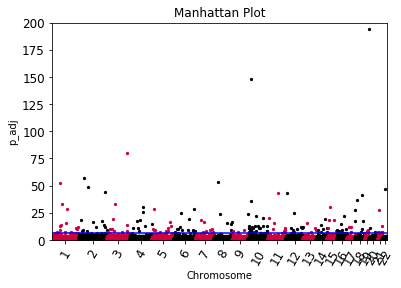

In [200]:
pd.set_option('expand_frame_repr', False)
df = pd.read_csv('T2Dfreq.csv')

    # HWE<0.05
    # allfreq<0.01

# df = df[df['pval_HW']>0.05]
# df = df[df['Minor_f_ctrl']>0.01]
# df = df[df['Minor_f_cases']>0.01]


df['p_adj'] = -np.log10(df['pval'])
df['Chrs'] = df['Chrs'].astype('category')

    # print(df.head(10))

df['ind'] = range(len(df))
df_grouped = df.groupby(('Chrs'))

    # print(df_grouped.head(10))

fig = plt.figure()
ax = fig.add_subplot(111)
colors = ['#cf003d','#000000']
x_labels = []
x_labels_pos = []
for num, (name, group) in enumerate(df_grouped):
    group.plot(kind='scatter', x='ind', y='p_adj',color=colors[num % len(colors)], ax=ax, s=5)
    x_labels.append(name)
    x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2))

ax.set_xticks(x_labels_pos)
ax.set_xticklabels(x_labels)
ax.set_xlim([0, len(df)])
ax.set_ylim([0, 200])
ax.set_xlabel('Chromosome')
plt.xticks(fontsize = 12,rotation=60)
plt.title('Manhattan Plot')
plt.yticks(fontsize = 12)

        # xticks = ax.xaxis.get_major_ticks()
        # xticks[0].set_visible(False)
plt.axhline(y=-np.log10(0.05/len(df)),color='b')
plt.show()

In [192]:
sig_everything = df[df['p_adj']>-np.log10(0.05/len(df))]
sig_everything.head()

,SNP,rsid,Chrs,Disease,Minor,Major,Minor_f_cases,Minor_f_ctrl,OR_major,pval,chi2,pval_HW,p_adj,ind
5694,SNP_A-1909086,rs1236920,1,T2D,g,c,0.068284,0.099368,0.664262,6.475754e-08,29.215546,0.892769,7.188710,5694
8671,SNP_A-1974312,rs10494526,1,T2D,a,g,0.071286,0.012650,5.991112,1.503829e-53,237.328622,0.482553,52.822802,8671
8965,SNP_A-1980111,rs16848754,1,T2D,c,g,0.009005,0.031625,0.278233,8.712570e-14,55.637942,0.549604,13.059854,8965
9387,SNP_A-1987836,rs853013,1,T2D,a,t,0.006253,0.022137,0.277957,4.299979e-10,38.971682,0.214688,9.366534,9387
10490,SNP_A-2026826,rs12064327,1,T2D,a,g,0.034517,0.012150,2.906629,2.395242e-14,58.177324,0.500220,13.620651,10490


In [17]:
## Write code to run the GWAS

## Write a function that will take the following inputs:
## (a) control files - 58C and NBS
## (b) the disease - T2D, T1D, HT, BD, CD, RA
## (c) the chromosome number

## Your function should output a csv file with the following information
## SNP Id, RSID, CHROMOSOME NUMBER, MINOR ALLELE, MAJOR ALLELE, MINOR ALLELE FREQUENCY, MAJOR ALLELE FREQUENCY, 
## ODDS RATIO (MINOR vs MAJOR ALLELE), P-Value for ODDS RATIO, Chi square for the ODDS RATIO, HWE deviation P-VALUE
## 

def gwas (controlFile, disease, chrom_num):
    """
    1. Load the control file for the specified chromosome number. Since there are two control populations, 
       it would be best to combine the two controls together
    2. Load the disease file for the given chromosome number
    3. Split the header from the SNP data for the controls and the disease
    3. Load the SNP file -- this gives you the mapping between the WTCCC SNP ids and the RSID
    4. For each SNP in the disease file and its matching SNP in the control file:
       -- to make it easier, before you begin do a check for zygosity. If either the controls or the disease 
       are homozygous, skip the SNP
       genotype CC, TT : skip
       genotype CC CT TT : run the following analysis
       a. get the minor and major allele counts and compute the minor allele frequency for the disease population
       b. get the minor and major allele counts and compute the minor allele frequency for the control population
       c. conduct the allelic test -- compute the odds ratios to test the frequency of the minor allele 
          in the disease population compared to the control population
          -- you can build a confusion matrix based on the counts that you have calculated in a and b
          -- compute your odds ratios based on the minor allele of the control population
          
          |                  | C    | T    | 
          |------------------+ ---  + ---  +
          | Bipolar Disorder | 1529 | 2469 |
          |------------------+----  + ---  +
          | Healthy Controls | 2270 | 3738 |
          |------------------+----- +----- +
          
          (Test : your OR for above should be :1.019)
       d. Do a chi square test to test the significant and record the p-value
       d. for each SNP calculate the deviation from Hardy-Weinberg equilibrium
       e. create an output row containing:
       SNP Id, RSID, CHROMOSOME NUMBER, MINOR ALLELE, MAJOR ALLELE, MINOR ALLELE FREQUENCY, 
       MAJOR ALLELE FREQUENCY, ODDS RATIO (MINOR vs MAJOR ALLELE), 
       P-Value for ODDS RATIO, CHI_SQ for the ODDS RATIO, HWE deviation P-VALUE  
    5. Save the result file for the chromosome
    """
    


In [18]:
## Write a main function that will invoke gwas for all chromosomes (1 through 22, don't include the X chromosome)

def runGWAS (disease):
    """
    1. For each chromosome 1:22 call the gwas function
    2. Merge all the result files into one 
    3. Filter your data
       a. remove all SNPs that deviate signficantly from HWE equilibrium -- these may indicate an error or 
          population specific deviation. For this remove all SNPs for which HWE deviation P-Value < 0.05
       b. remove all SNPs that have minor allele frequency less than 1% -- not enough data
    4. Draw a manhattan plot
       c. draw a line at your Bonferroni threshold (Bonferroni correction): 
       if your significance is set at p.value < 0.05, then Bonferroni correction = 0.05/number of tests that you ran
    """

<img src="manhattan.png">

In [ ]:
## How many SNPs did you identify that exceeded the Bonferroni-level of significance?

## How much can you trust your results

Typically, you want to examine the genome-wide distribution of your chi_square distribution against an expected null distribution. Visually you can do this using a quantile-quantile plot. Significant deviation from the null distribution may point to population stratification, familial relationships, technical bias, poor sample collection or sometimes even undetected sample duplications.
(Slide courtesy - Dr. Chirag Patel)

<img src="qqplot_example.png">


In [20]:
## Based on your results do a quantile-quantile plot for your data

##load your results 
##sort/order the -log10 of your p values in increasing order
##generate an expected set of -log10(p_values)
##plot the expected values on the x-axis and the observed -log10 (pvalues) on the y axis
##Alternatively use: p = observed p values
##stats.probplot(p, dist="norm", plot=pylab)
##pylab.show()


### Genomic Inflation Factor

Mathematically, you can correct for some of the deviation by computing an inflation factor and then correcting for this inflation factor. This quantity is termed as genomic inflation factor ($\lambda$)

$\lambda$ = observed median of test statistic distribution / expected median of the test statistic 
distribution.  For 1 degree of freedom, the X2 distribution has an expected median of 0.455

$\lambda$ <= 1.05 is considered acceptable. >1.1 is troubling, and indicates there is some inflation of the p values.


In [ ]:
## Compute the genomic inflation factor

##labmda =  median(CHI2)/qchisq(0.5, 1)
##if (gif > 1.05), correct your computed Chi.square values and recompute the p_values
##chi2_corrected = CHI2/lambda, 
##pval_corrected = pchisq(chi2_corrected, 1, lower.tail = F)
##re-draw the qqplot using the corrected pvalues (pval_corrected)


## What does this mean?

Identify a SNP that is significant (above the Bonferroni threshold). 
What is the p-value of association and odds ratio for the SNP?
What is the interpretation of the odds ratio? 
What gene is this SNP associated with and its putative function in your disease pathogenesis? 


## Polygenic Risk Scores (PRS)

A PRS is the cumulative risk of all SNP for a single patient. For example, if a patient has a 2 snps with OR=2 each, then their PRS is 4. The underlying assumption here is that each allele has an equal contribution and there is no interation between SNPS, that is the SNPS are independent. 

$prs =\sum_{i=1}^{m}-log_{10}(x_i) \cdot n_i$

In [135]:
sigsnps

,chr,snp_name,dis maj all,rs,con min all,dis min all,con maj all,dis maj all.1,con maj all freq,dis maj all freq,odds rat,p,HWE,p_adj,ind
1556,16.0,SNP_A-2037492,52368187,NaN,C,T,C,T,0.394614,0.454227,1.276793,6.822692e-07,0.931499,6.166044,521


In [129]:
st.head()

,1,3,4,5,6,7,8,9,10,11,...,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002
0,SNP_A-1839415,81402874,C C,C C,C C,C C,C C,C C,C C,C C,...,C G,G G,C G,C C,C G,C G,C C,C C,C C,C C
1,SNP_A-2195647,17148629,C C,C C,C C,C C,C C,C C,C C,C C,...,C C,C C,C C,C C,C C,C C,C C,C C,C C,C C
2,SNP_A-2158594,74832948,A A,A A,A A,A A,A A,A A,A A,A A,...,A G,A G,A A,A A,A G,A A,A G,A G,A A,A G
3,SNP_A-2284990,19971996,A A,A C,A C,C C,A A,A C,A C,A C,...,C C,A C,A C,C C,A C,A C,A A,A C,C C,A C
4,SNP_A-4240990,8189275,A G,G G,A G,A G,G G,G G,G G,G G,...,G G,A A,A G,A A,G G,G G,A G,A G,G G,A G


In [168]:
largedf = pd.DataFrame()

st = loadFile('T2D',16)
st = st.drop([0,2],axis=1)
the_snp = sigsnps['snp_name'].loc[1556]
the_or = sigsnps['odds rat'].loc[1556]
the_min_all = sigsnps['con min all'].loc[1556]
the_sig_snp = st[st[1]==the_snp]
prs_df=pd.DataFrame()

In [169]:
for i in range(1999):
    prs=0
    i=i+4
    prs = the_sig_snp[i].loc[56].count(the_min_all)*the_or
    prs_df=prs_df.append(pd.DataFrame(np.array([i,prs]).reshape(1,2)))

[Text(0, 0, '0.000'), Text(0, 0, '1.277'), Text(0, 0, '2.554')]

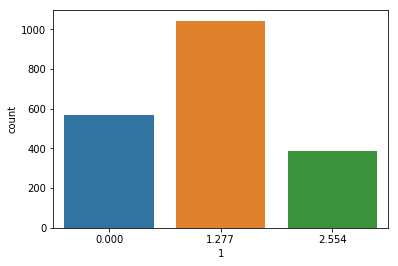

In [177]:
import seaborn as sns
etplt = sns.countplot(x = 1, data = prs_df)
etplt.set_xticklabels(labels=['0.000', '1.277', '2.554'])

In [193]:
def load1000File (disease, chrom_num):
    ## construct your file name based on the disease and chrom_number
    if chrom_num<10:
        stro = '0'+str(chrom_num)
    else:
        stro = str(chrom_num)
    fileName = 'BWSI_test/'+disease+'/Affx_gt_'+disease+'_Chiamo_'+stro+'.tped.gz'
    dat = pd.read_csv(fileName, compression='gzip', header=None, sep='\t')
    return (dat)